<a href="https://colab.research.google.com/github/PorusSuntoke/CIFAR-10-Classification/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch torchvision
!pip3 install pillow==7.1.2

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform_train = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
                                transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])
training_dataset = datasets.CIFAR10(root='./data', train = True, download = True, transform = transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train = False, download = True, transform = transform)

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 100, shuffle = False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


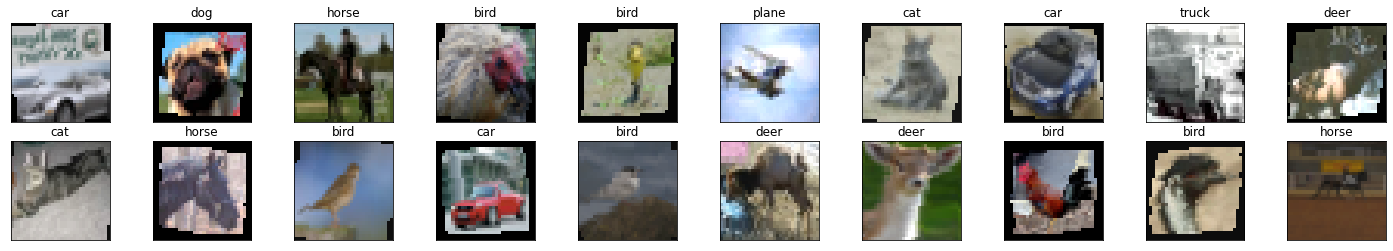

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [ ]:
class LeNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = 1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [ ]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)


    epoch_loss = running_loss/ len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    print('epoch:', (e+1))
    print('training loss: {:.4f}, accuracy: {:.4f} '.format(epoch_loss, epoch_acc.item()))

    val_epoch_loss = val_running_loss/ len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('validation loss: {:.4f}, validation accuracy: {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch: 1
training loss: 1.6893, accuracy: 38.2060 
validation loss: 1.3949, validation accuracy: 49.1800 
epoch: 2
training loss: 1.3983, accuracy: 49.3100 
validation loss: 1.2410, validation accuracy: 55.1400 
epoch: 3
training loss: 1.2670, accuracy: 54.7740 
validation loss: 1.1136, validation accuracy: 60.5400 
epoch: 4
training loss: 1.1798, accuracy: 57.8680 
validation loss: 1.0792, validation accuracy: 61.8400 
epoch: 5
training loss: 1.1121, accuracy: 60.7420 
validation loss: 1.0277, validation accuracy: 64.1800 
epoch: 6
training loss: 1.0513, accuracy: 62.8920 
validation loss: 0.9561, validation accuracy: 66.4600 
epoch: 7
training loss: 1.0052, accuracy: 64.5120 
validation loss: 0.9180, validation accuracy: 67.7700 
epoch: 8
training loss: 0.9730, accuracy: 65.5500 
validation loss: 0.8863, validation accuracy: 69.7000 
epoch: 9
training loss: 0.9438, accuracy: 66.7180 
validation loss: 0.8677, validation accuracy: 69.9500 
epoch: 10
training loss: 0.9268, accuracy: 67.

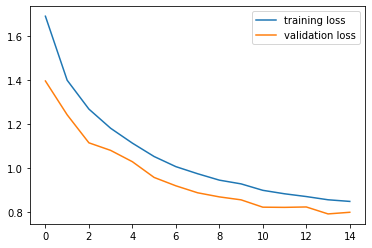

In [ ]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()

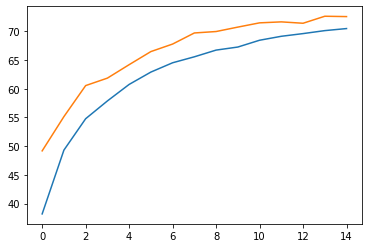

In [ ]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')

In [ ]:
import PIL.ImageOps

<Response [200]>


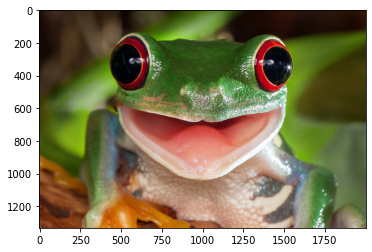

In [ ]:
import requests
from PIL import Image
url = 'https://s3-prod.chicagobusiness.com/s3fs-public/frog-WEB_i.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

(32, 32, 3)


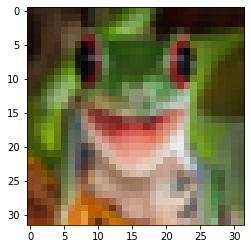

In [ ]:
img = transform(img)
plt.imshow(im_convert(img))

In [ ]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

horse


(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


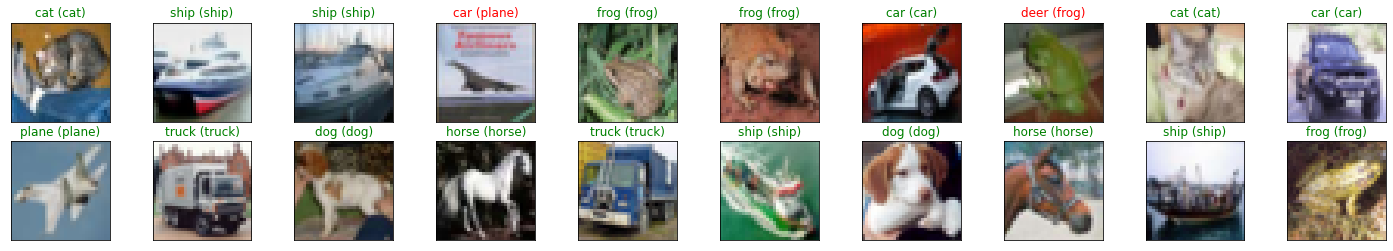

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx]== labels[idx] else "red"))

<Response [200]>


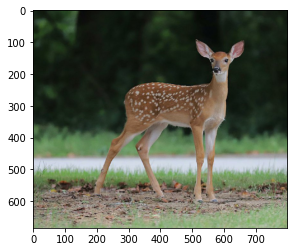

In [ ]:
import requests
from PIL import Image
url = 'https://media.arkansasonline.com/img/photos/2019/06/17/resized_250499-1b-deer-0618_85-26607_t800.JPG?90232451fbcadccc64a17de7521d859a8f88077d'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

(32, 32, 3)


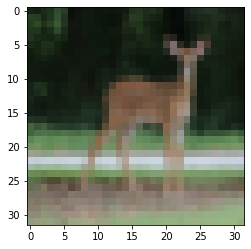

In [ ]:
img = transform(img)
plt.imshow(im_convert(img))

In [ ]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


<Response [200]>


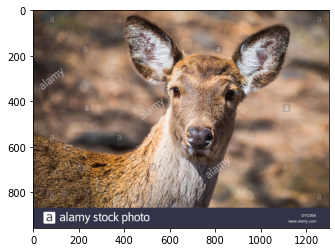

In [ ]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

(32, 32, 3)


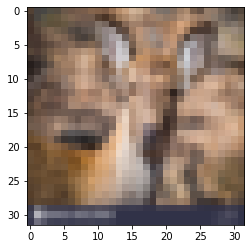

In [ ]:
img = transform(img)
plt.imshow(im_convert(img))

In [ ]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer
